In [321]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

data = {
    "t": [
        0.01, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.11, 0.12, 0.13, 0.15, 0.16, 0.17, 0.19, 0.20, 0.21, 0.23, 0.24, 0.25,
        0.27, 0.28, 0.29, 0.31, 0.32, 0.33, 0.35, 0.36, 0.37, 0.39, 0.40, 0.41, 0.43, 0.44, 0.45, 0.47, 0.48, 0.49,
        0.51, 0.52, 0.53, 0.55, 0.56, 0.57, 0.59, 0.60, 0.61, 0.63, 0.64, 0.65, 0.67, 0.68, 0.69, 0.71, 0.72, 0.73,
        0.75, 0.76, 0.77, 0.79, 0.80, 0.81, 0.83, 0.84, 0.85, 0.87, 0.88, 0.89, 0.91, 0.92, 0.93, 0.95, 0.96, 0.97,
        0.99, 1.00
    ],
    "y_t": [
        8.4036, 8.5289, 8.5908, 8.6985, 8.7224, 8.8667, 8.905, 9.0293, 9.1406, 9.1957, 9.331, 9.4345, 9.5152, 9.6381,
        9.7421, 9.8697, 9.9798, 10.0344, 10.1508, 10.285, 10.3852, 10.4737, 10.5987, 10.7176, 10.9199, 10.9765, 11.1153,
        11.2144, 11.3673, 11.4957, 11.6675, 11.7576, 11.9449, 12.0506, 12.2335, 12.3129, 12.495, 12.6191, 12.7703,
        12.9467, 13.1468, 13.2562, 13.4075, 13.5828, 13.7512, 13.9487, 14.1078, 14.2864, 14.4849, 14.6396, 14.8434,
        15.0758, 15.1903, 15.4322, 15.6338, 15.7893, 16.0034, 16.2994, 16.4977, 16.7112, 16.9406, 17.0747, 17.3322,
        17.6035, 17.8129, 18.0888, 18.2903, 18.5493, 18.8428, 19.0455, 19.3245, 19.5743, 19.9263, 20.1586, 20.4232
    ]
}

df = pd.DataFrame(data)

df.head(), df.describe()


(      t     y_t
 0  0.01  8.4036
 1  0.03  8.5289
 2  0.04  8.5908
 3  0.05  8.6985
 4  0.07  8.7224,
                t        y_t
 count  75.000000  75.000000
 mean    0.506667  13.242672
 std     0.290658   3.494301
 min     0.010000   8.403600
 25%     0.260000  10.217900
 50%     0.510000  12.619100
 75%     0.755000  15.896350
 max     1.000000  20.423200)

In [337]:
t = np.array(data['t'])
y = np.array(data['y_t'])

def model1(t, alpha0, alpha1, alpha2, beta1, beta2):
    return alpha0 + alpha1 * np.exp(beta1 * t) + alpha2 * np.exp(beta2 * t)

def residuals(params, t, y):
    return y - model1(t, *params)

def jacobian(t, params):
    alpha0, alpha1, alpha2, beta1, beta2 = params
    J = np.zeros((len(t), len(params)))
    J[:, 0] = 1  
    J[:, 1] = np.exp(beta1 * t) 
    J[:, 2] = np.exp(beta2 * t)  
    J[:, 3] = alpha1 * t * np.exp(beta1 * t) 
    J[:, 4] = alpha2 * t * np.exp(beta2 * t) 
    return J

def gauss_newton(t, y, initial_params, tol=1e-6, max_iter=100, lambda_reg=1e-5):
    params = np.array(initial_params)
    for i in range(max_iter):
        res = residuals(params, t, y)
        J = jacobian(t, params)
        
        JTJ = J.T @ J + lambda_reg * np.eye(J.shape[1]) 
        JTr = J.T @ res
        try:
            delta = np.linalg.solve(JTJ, JTr)
        except np.linalg.LinAlgError:
            print("Singular matrix encountered. Try different initial parameters.")
            return params
        
        params = params + delta
        
        if np.linalg.norm(delta) < tol:
            print(f"Converged in {i+1} iterations")
            break
    else:
        print("Maximum iterations reached without convergence")
        
    return params

initial_params = [8, 2, 2, 0.1, 1] 
estimated_params = gauss_newton(t, y, initial_params)
print("Estimated parameters:", estimated_params)

Converged in 20 iterations
Estimated parameters: [ 3.6684776  -0.06952842  4.73464233 -3.45303786  1.26400552]


In [323]:
import numpy as np

def model2(t, alpha0, alpha1, beta0, beta1):
    return (alpha0 + alpha1 * t) / (beta0 + beta1 * t)

def residuals_v2(params, t, y):
    return y - model2(t, *params)

def jacobian_v2(t, params):
    alpha0, alpha1, beta0, beta1 = params
    J = np.zeros((len(t), len(params)))
    J[:, 0] = 1 / (beta0 + beta1 * t)
    J[:, 1] = t / (beta0 + beta1 * t)
    J[:, 2] = -(alpha0 + alpha1 * t) / (beta0 + beta1 * t)**2
    J[:, 3] = -(alpha0 + alpha1 * t) * t / (beta0 + beta1 * t)**2
    return J

def gauss_newton_v2(t, y, initial_params, tol=1e-6, max_iter=100, lambda_reg=1e-5):
    params = np.array(initial_params)
    for i in range(max_iter):
        res = residuals_v2(params, t, y)
        J = jacobian_v2(t, params)
        
        JTJ = J.T @ J + lambda_reg * np.eye(J.shape[1])
        JTr = J.T @ res
        try:
            delta = np.linalg.solve(JTJ, JTr)
        except np.linalg.LinAlgError:
            print("Encountered a singular matrix. Try different initial parameters.")
            return params
        
        params += delta
        
        if np.linalg.norm(delta) < tol:
            print(f"Converged in {i+1} iterations")
            break
    else:
        print("Reached max iterations without convergence")
        
    return params

initial_params_v2 = [1, 1, 0.1, 0.1]
estimated_params_v2 = gauss_newton_v2(t, y, initial_params_v2)
print("Estimated parameters (model2_v2):", estimated_params_v2)


Converged in 7 iterations
Estimated parameters (model2_v2): [ 1.53786666  0.53595304  0.18583855 -0.08462925]


In [324]:
import numpy as np

def model3(t, beta0, beta1, beta2, beta3, beta4):
    return beta0 + beta1 * t + beta2 * t**2 + beta3 * t**3 + beta4 * t**4

def residuals_v3(params, t, y):
    return y - model3(t, *params)

def jacobian_v3(t, params):
    beta0, beta1, beta2, beta3, beta4 = params
    J = np.zeros((len(t), len(params)))
    J[:, 0] = 1
    J[:, 1] = t
    J[:, 2] = t**2
    J[:, 3] = t**3
    J[:, 4] = t**4
    return J

def gauss_newton_v3(t, y, initial_params, tol=1e-6, max_iter=100, lambda_reg=1e-5):
    params = np.array(initial_params, dtype=float)
    
    for i in range(max_iter):
        res = residuals_v3(params, t, y)
        J = jacobian_v3(t, params)
        
        JTJ = J.T @ J + lambda_reg * np.eye(J.shape[1])
        JTr = J.T @ res
        try:
            delta = np.linalg.solve(JTJ, JTr)
        except np.linalg.LinAlgError:
            print("Encountered a singular matrix. Try different initial parameters.")
            return params
        
        params += delta
        
        if np.linalg.norm(delta) < tol:
            print(f"Converged in {i+1} iterations")
            break
    else:
        print("Reached max iterations without convergence")
        
    return params

initial_params_v3 = [8.4, 6, 0.1, 0.1, 0.1]
estimated_params_v3 = gauss_newton_v3(t, y, initial_params_v3)
print("Estimated parameters (model3):", estimated_params_v3)


Converged in 6 iterations
Estimated parameters (model3): [8.33269021 6.22921002 3.44120743 1.66757847 0.75159687]


In [325]:
def calculate_mse(model, params, t, y):
    predictions = model(t, *params)
    return np.mean((y - predictions) ** 2)

mse4 = calculate_mse(model1, estimated_params, t, y)
mse5 = calculate_mse(model2, estimated_params_v2, t, y)
mse6 = calculate_mse(model3, estimated_params_v3, t, y)

print("Model 1 MSE:", mse4)
print("Model 2 MSE:", mse5)
print("Model 3 MSE:", mse6)

Model 1 MSE: 0.002255608793751518
Model 2 MSE: 0.0028908004591520066
Model 3 MSE: 0.0022534387804778473


The best fitted model is model 3

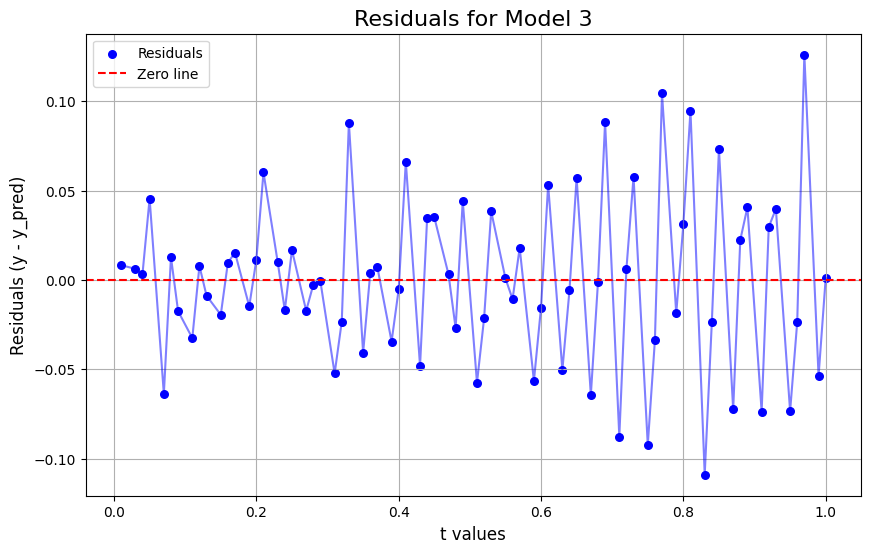

In [326]:
import matplotlib.pyplot as plt

y_pred_model3 = model3(np.array(t), *estimated_params_v3)
residuals_model3 = y - y_pred_model3
plt.figure(figsize=(10, 6))
plt.scatter(t, residuals_model3, color='blue', label='Residuals', s=30)
plt.plot(t, residuals_model3, color='blue', linestyle='-', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', label='Zero line')
plt.title('Residuals for Model 3', fontsize=16)
plt.xlabel('t values', fontsize=12)
plt.ylabel('Residuals (y - y_pred)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

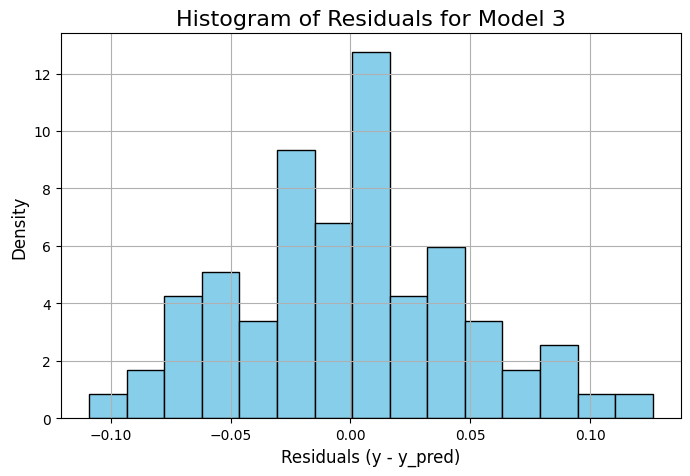

In [327]:
plt.figure(figsize=(8, 5))
plt.hist(residuals_model3, bins=15, color='skyblue', edgecolor='black', density=True)
plt.title('Histogram of Residuals for Model 3', fontsize=16)
plt.xlabel('Residuals (y - y_pred)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

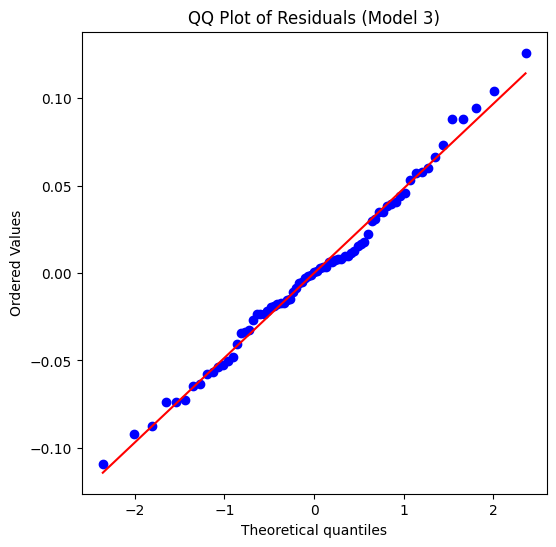

In [328]:
plt.figure(figsize=(6, 6))
stats.probplot(residuals_model3, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Model 3)")
plt.show()


In [329]:
from scipy.stats import normaltest

stat, p_value = normaltest(residuals_model3)
const = 0.05 
print(f"Test statistic: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value > const:
    print("The residuals follow normal distribution.")
else:
    print("The residuals do not follow normal distribution.")

Test statistic: 0.7357
p-value: 0.6922
The residuals follow normal distribution.


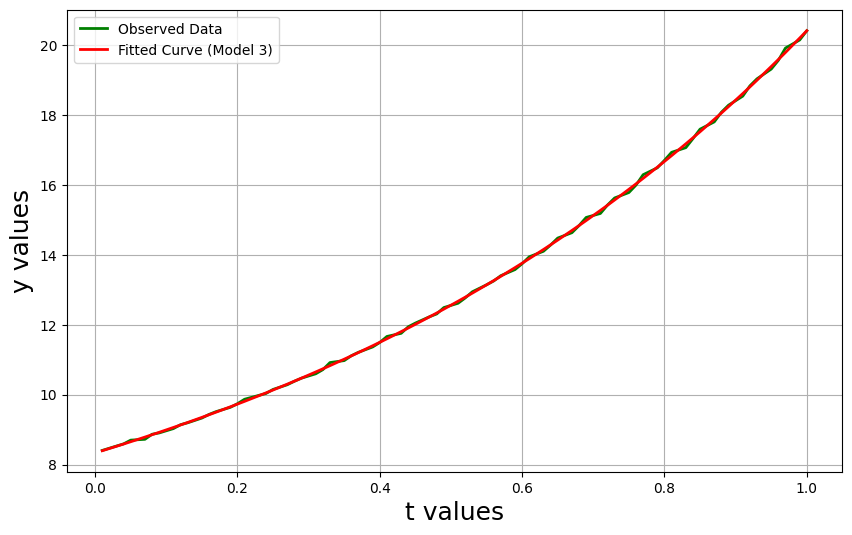

In [330]:
import numpy as np
import matplotlib.pyplot as plt

params3 = np.polyfit(t, y, 4)

y_pred_model3 = params3[0] * t**4 + params3[1] * t**3 + params3[2] * t**2 + params3[3] * t + params3[4]

plt.figure(figsize=(10, 6))
plt.plot(t, y, color='green', label='Observed Data', linewidth=2)
plt.plot(t, y_pred_model3, color='red', label='Fitted Curve (Model 3)', linewidth=2)
plt.xlabel('t values', fontsize=18)
plt.ylabel('y values', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [331]:
p = 5

n = len(t)

residuals_model3 = y - y_pred_model3

sigma_squared_estimate = np.sum(residuals_model3**2) / (n - p)

print("Estimated σ^2 for model 3 (best fit):", sigma_squared_estimate)

Estimated σ^2 for model 3 (best fit): 0.0024143986933690908


In [332]:
p = 5

n = len(t)

y_pred_model1 = model1(np.array(t), *estimated_params)
residuals_model1 = y - y_pred_model1

sigma_squared_estimate1 = np.sum(residuals_model1**2) / (n - p)

print("Estimated σ^2 for model 1:", sigma_squared_estimate1)

Estimated σ^2 for model 1: 0.0024167237075909125


In [333]:
p = 4

n = len(t)

y_pred_model2 = model2(np.array(t), *estimated_params_v2)
residuals_model2 = y - y_pred_model2

sigma_squared_estimate2 = np.sum(residuals_model2**2) / (n - p)

print("Estimated σ^2 for model 2:", sigma_squared_estimate2)

Estimated σ^2 for model 2: 0.003053662456850711


In [334]:
from scipy.stats import norm

def fisher_information_matrix(jacobian, sigma_squared):
    JTJ = jacobian.T @ jacobian
    covariance_matrix = sigma_squared * np.linalg.inv(JTJ)
    return covariance_matrix

J_estimated = jacobian_v3(t, estimated_params_v3)
covariance_matrix = fisher_information_matrix(J_estimated, sigma_squared_estimate)
standard_errors = np.sqrt(np.diag(covariance_matrix))

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

confidence_intervals = [
    (param - z_score * std_err, param + z_score * std_err)
    for param, std_err in zip(estimated_params_v3, standard_errors)
]

for i, (param, ci) in enumerate(zip(estimated_params_v3, confidence_intervals)):
    print(f"Parameter beta{i}: Estimate = {param:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")


Parameter beta0: Estimate = 8.3327, 95% CI = (8.2727, 8.3926)
Parameter beta1: Estimate = 6.2292, 95% CI = (5.4214, 7.0371)
Parameter beta2: Estimate = 3.4412, 95% CI = (0.2283, 6.6541)
Parameter beta3: Estimate = 1.6676, 95% CI = (-3.0827, 6.4178)
Parameter beta4: Estimate = 0.7516, 95% CI = (-1.5747, 3.0779)


In [335]:
def fisher_information_matrix(jacobian, sigma_squared):
    JTJ = jacobian.T @ jacobian
    covariance_matrix = sigma_squared * np.linalg.inv(JTJ)
    return covariance_matrix

J_estimated = jacobian(t, estimated_params)
covariance_matrix = fisher_information_matrix(J_estimated, sigma_squared_estimate1)
standard_errors = np.sqrt(np.diag(covariance_matrix))

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

confidence_intervals = [
    (param - z_score * std_err, param + z_score * std_err)
    for param, std_err in zip(estimated_params, standard_errors)
]

for i, (param, ci) in enumerate(zip(estimated_params, confidence_intervals)):
    if(i<3):
        print(f"Parameter alpha{i}: Estimate = {param:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")
    else :
        print(f"Parameter beta{i-2}: Estimate = {param:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

Parameter alpha0: Estimate = 3.6688, 95% CI = (0.4644, 6.8731)
Parameter alpha1: Estimate = -0.0696, 95% CI = (-1.2754, 1.1361)
Parameter alpha2: Estimate = 4.7345, 95% CI = (2.7692, 6.6998)
Parameter beta1: Estimate = -3.4480, 95% CI = (-57.6617, 50.7657)
Parameter beta2: Estimate = 1.2640, 95% CI = (1.0288, 1.4993)


In [336]:
def fisher_information_matrix(jacobian, sigma_squared, lambda_reg=1e-5):
    JTJ = jacobian.T @ jacobian
    JTJ += lambda_reg * np.eye(JTJ.shape[0])
    covariance_matrix = sigma_squared * np.linalg.inv(JTJ)
    return covariance_matrix

J_estimated = jacobian_v2(t, estimated_params_v2)
covariance_matrix = fisher_information_matrix(J_estimated, sigma_squared_estimate2)
standard_errors = np.sqrt(np.diag(covariance_matrix))

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

confidence_intervals = [
    (param - z_score * std_err, param + z_score * std_err)
    for param, std_err in zip(estimated_params_v2, standard_errors)
]

for i, (param, ci) in enumerate(zip(estimated_params_v2, confidence_intervals)):
    if(i<2):
        print(f"Parameter alpha{i}: Estimate = {param:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")
    else :
        print(f"Parameter beta{i-2}: Estimate = {param:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

Parameter alpha0: Estimate = 1.5379, 95% CI = (-30.5529, 33.6287)
Parameter alpha1: Estimate = 0.5360, 95% CI = (-10.6479, 11.7198)
Parameter beta0: Estimate = 0.1858, 95% CI = (-3.6921, 4.0637)
Parameter beta1: Estimate = -0.0846, 95% CI = (-1.8506, 1.6813)
